## process C3D files into time series of marker data
- c3d file is a F x n x (x,y,z) dimension file, where F = number of frames, n = number of markers detected from acquisition
- labels are stored in reader.point_labels

In [6]:
import c3d 
import numpy as np
import matplotlib.pyplot as plt
import tools
import math

In [2]:
# sampling rate is 200 Hz
# Open the .c3d file
with open('/Users/anqizhou/FastTrack/sampleData_11-15-2024/Sain_2019_11_15_DAp_GBMOV_T1_OFF_GNG_GAIT_001.c3d', 'rb') as f:
    reader = c3d.Reader(f)
    
    # Initialize data structures to store extracted data
    markers = []
    frame_numbers = []

    # Iterate over frames
    #for i, (points, analog) in enumerate(reader.read_frames()):
    for i, points in enumerate(reader.read_frames()):
        frame_numbers.append(i)
        markers.append(points[1][:,:3])  # Extract 3D positions (x, y, z), which are the first three values stored in the 1st tuple position
        #analog_data.append(analog)    # Extract analog signals (e.g., force plates)

# Convert to numpy arrays for easier manipulation
import numpy as np
markers = np.array(markers)        # Shape: (frames, markers, 3)
markers = np.transpose(markers, (1, 2, 0)) # change the shape so that it is (markers, 3, frames)

# create a dataset with label dictionary
data = {
    'marker_labels': reader.point_labels,
    'time_series_raw': tools.replace_zeros_with_neighbors_mean(markers,1),
    # to clean the data, let's assume that processes are linear over 3 timesteps (+1/-1 on each side)
    # or 
    # complete raw data
    #'time_series_raw': markers 
}

# data['marker_labels'] # test to retrieve marker labels from the data, note that labels that start with * are unlabled markers

# visualize the raw data

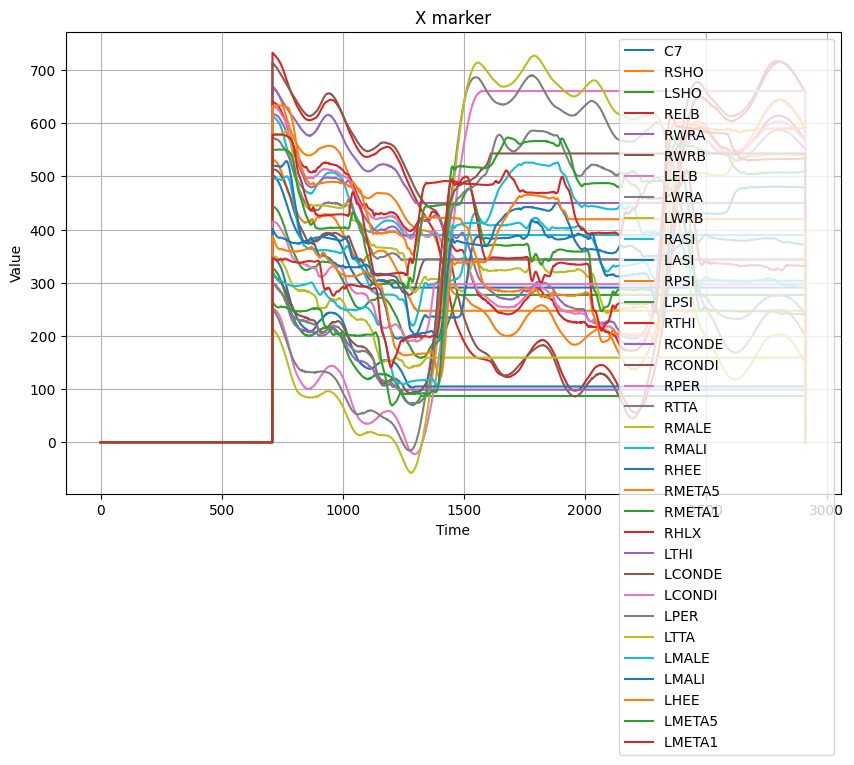

In [4]:
# x,y,z info for each marker i is stored as data['time_series_raw'][i][0], [i][1], or [i][2]
plot_title = ['X','Y','Z']
fig,axs = plt.subplots(1,3, figsize=(11,8), dpi=300)
    for d in range(2): # recursive over three dimensions
        for i in range(len(34)):
            axs[d].plot(np.linspace(0, len(data['time_series_raw'][0][0]), num=len(data['time_series_raw'][0][0])), 
                data['time_series_raw'][i][d], 
                #label=data['marker_labels'][i]
            )
        axs[d].set_title(plot_title[d])
        axs[d].set_xlabel('Frame number')

        axs[d].spines.right.set_visible(False)
        axs[d].spines.top.set_visible(False)
    #plt.savefig('{}/lineplot.svg'.format(output), format='svg')
    #plt.savefig('{}/lineplot.pdf'.format(output), format='pdf')
plt.legend()
plt.show()

# Egocentric measurement
- let's find a central point between all markers, assuming that the markers are uniformly distributed
- convert the markers from space coordinates into vector coordinates from the center

In [16]:
center = np.mean(data['time_series_raw'], axis=0)

# transform marker data
ego = []
for i in range(len(reader.point_labels)):
    ego.append(data['time_series_raw'][i] - center) # compute euclidean distance
ego = np.array(ego)

# now normalize by the size of vector
magnitude=[]
for i in range(len(reader.point_labels)):
    for t in range(len(ego[i,0])):
        # compute square root of sum of squares across position for all axes
        # to compute magnitude of the vector
        magnitude.append(math.hypot(ego[i,0,t], ego[i,1,t], ego[i,2,t]))
magnitude = np.reshape(np.array(magnitude),(len(reader.point_labels),len(ego[i,0])))
# broadcast and normalized the coordinates
ego_normalized = ego/magnitude[:,np.newaxis,:]
ego_normalized = {'time_series_centered': np.array(ego_normalized)}
data.update(ego_normalized)

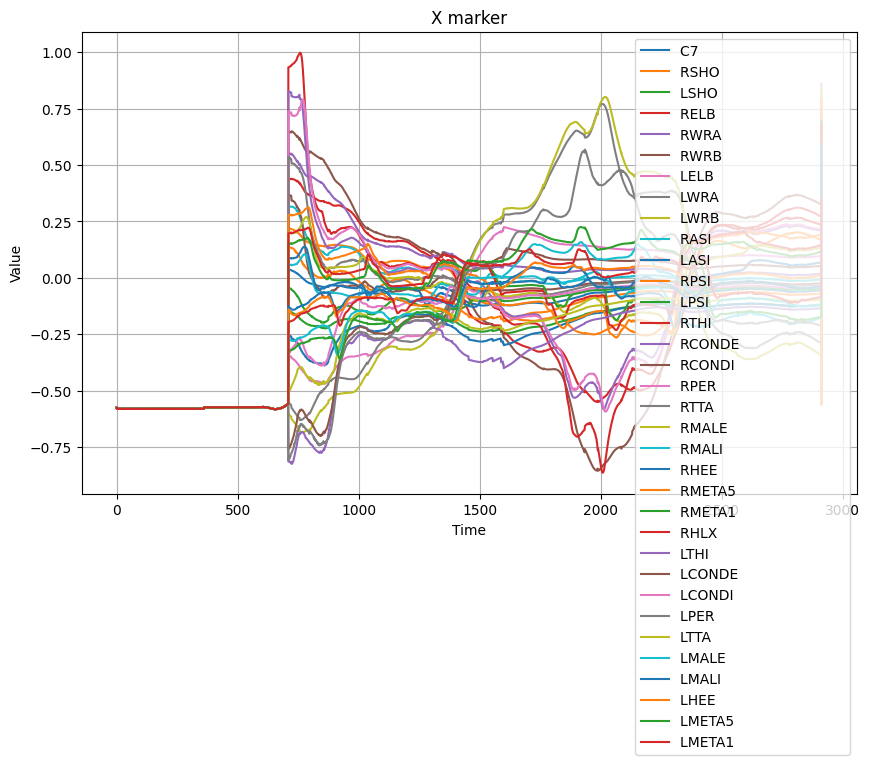

In [17]:
plt.figure(figsize=(10, 6))
for i in range(34): # there are a total of 34 known markers
#for i in range(len(data['time_series_raw'])): # total length includes markers that were dropped
    plt.plot(np.linspace(0, len(data['time_series_raw'][0][0]), num=len(data['time_series_raw'][0][0])), 
        data['time_series_centered'][i][0], label=data['marker_labels'][i])
plt.title('X marker normalized by vector length')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Example 3D time series array (72 markers, 3 features, 2719 timesteps)
n_samples = 72
n_features = 3
n_timesteps = 2719
data = np.random.rand(n_samples, n_features, n_timesteps)  # Simulated data

# Parameters
look_back = 10  # Number of past time steps to use for predicting the next timestep
future_step = 1  # Predict the next step (you can adjust this to predict more steps ahead)

# Prepare the data
X = []  # Features
y = []  # Targets

# Loop over each marker (sample) and create windows of past data
for i in range(n_samples):
    for j in range(n_timesteps - look_back - future_step):  # Ensure there is enough data for the look-back and prediction
        # Create the feature window (look_back past time steps)
        X.append(data[i, :, j:j + look_back].T)  # Transpose to shape (look_back, n_features)
        
        # Create the target (value at the next time step)
        y.append(data[i, :, j + look_back + future_step - 1])  # Get the value at the next time step

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Check the shape of the resulting data
print("Features shape:", X.shape)  # (n_samples * (n_timesteps - look_back - future_step), look_back, n_features)
print("Targets shape:", y.shape)   # (n_samples * (n_timesteps - look_back - future_step), n_features)


In [ ]:
# a simple logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Flatten the features for use in classifiers like Logistic Regression
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # Flatten the time steps and features
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Create a logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_2d, y_train)

# Predict on the test set
y_pred = model.predict(X_test_2d)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# MLP neural network using Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Create a neural network model
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))  # Flatten the input (look_back, n_features)
model.add(Dense(64, activation='relu'))  # Hidden layer with ReLU activation
model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes (assuming 3 class labels)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")